# 1. Preprocess the data and build word frequency dictionary

**count_tweets()** function takes the list of tweets and labels as input, cleans all tweets using process_tweet() function and returns a dictionary that storing tuple of stemmed word and its label(0,1) as key and the number of times this word appears as value.

In [1]:
def count_tweets(result, tweets, ys):
    '''
    Input:
        result: a dictionary that will be used to map each pair to its frequency
        tweets: a list of tweets
        ys: a list corresponding to the sentiment of each tweet (either 0 or 1)
    Output:
        result: a dictionary mapping each pair to its frequency
    '''

    for y, tweet in zip(ys, tweets):
        for word in process_tweet(tweet):
            pair = (word,y)

            # if the key exists in the dictionary, increment the count
            if pair in result:
                result[pair] += 1

            # else, if the key is new, add it to the dictionary and set the count to 1
            else:
                result[pair] = 1
    return result

**process_tweet()** is a helper function for preprocessing the dataset that tokenizes the text into separate words, converts words to stems, lowercase all letters and removes stop words and punctuations.

In [2]:
def process_tweet(tweet):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    
    # tokenize tweets
    # preserve_case = False for lowercasing all letters
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    
    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

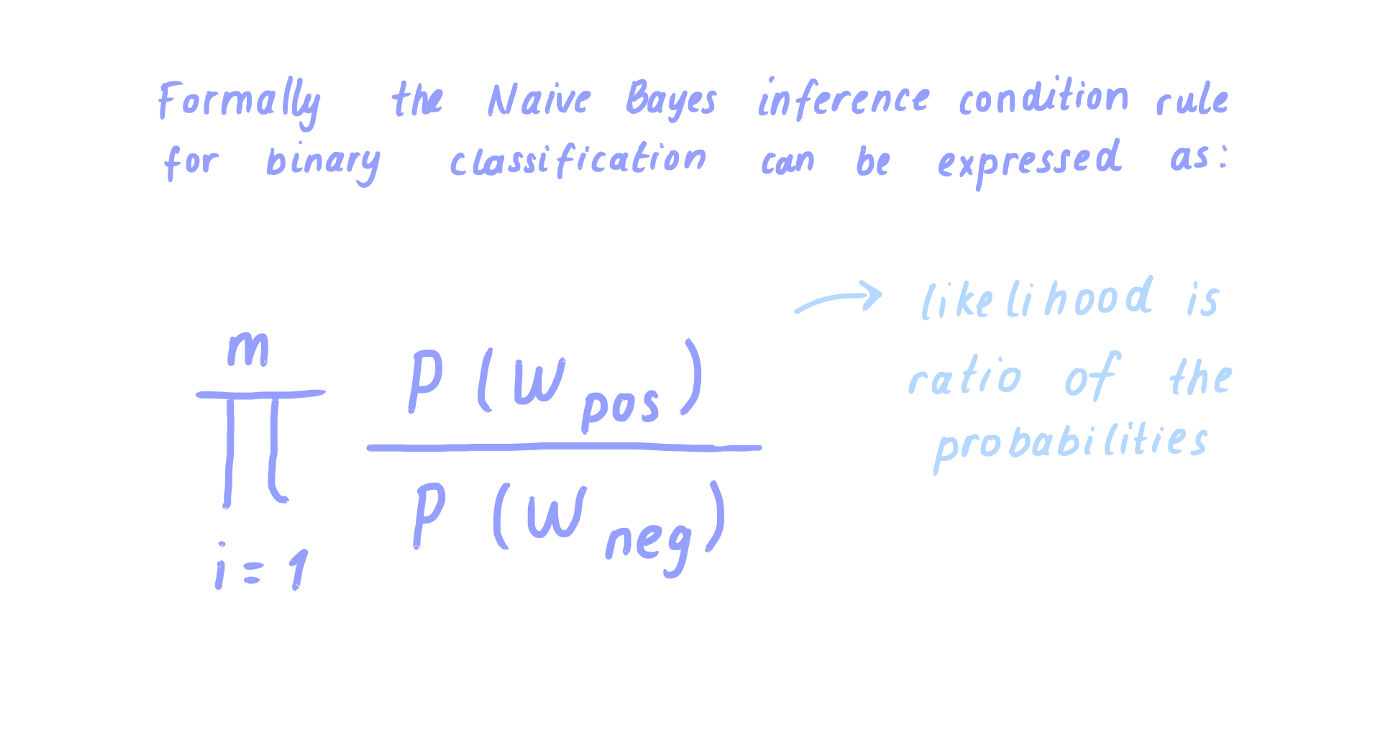

In [5]:
from IPython.display import Image
Image("images/nb.png", width=500)

# 2. Train a model using Naive Bayes: 

Naive Bayes is a supervised machine learning algorithm, and it relies on word frequency counts like logistic regression. Before implementing the Naive Bayes algorithm there are 2 important terms that we need to understand, these are **log likelihood and log prior**.

# Likelihood

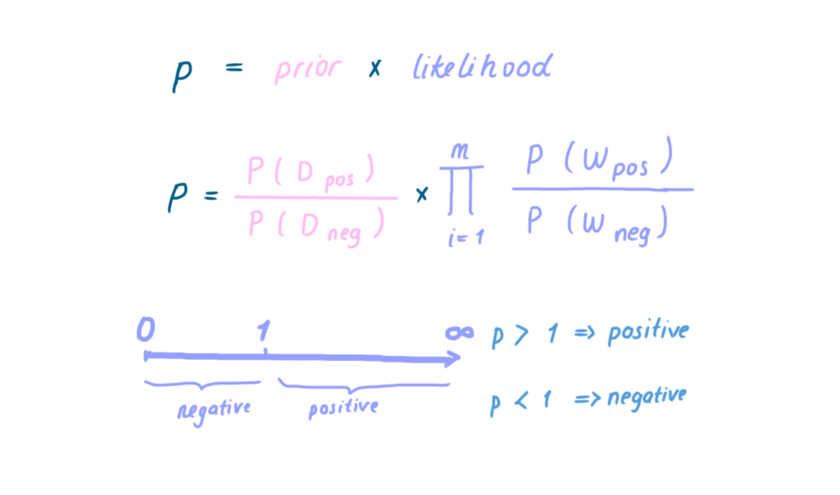

In [4]:
from IPython.display import Image
Image("images/likelihood.png", width=500)

**Likelihood** is the product of ratios of positive probability to negative probability for each word in the tweet. When likelihood value is higher than 1, we can predict this tweet as positive so that the words in the tweet collectively correspond positive sentiment.

# Prior

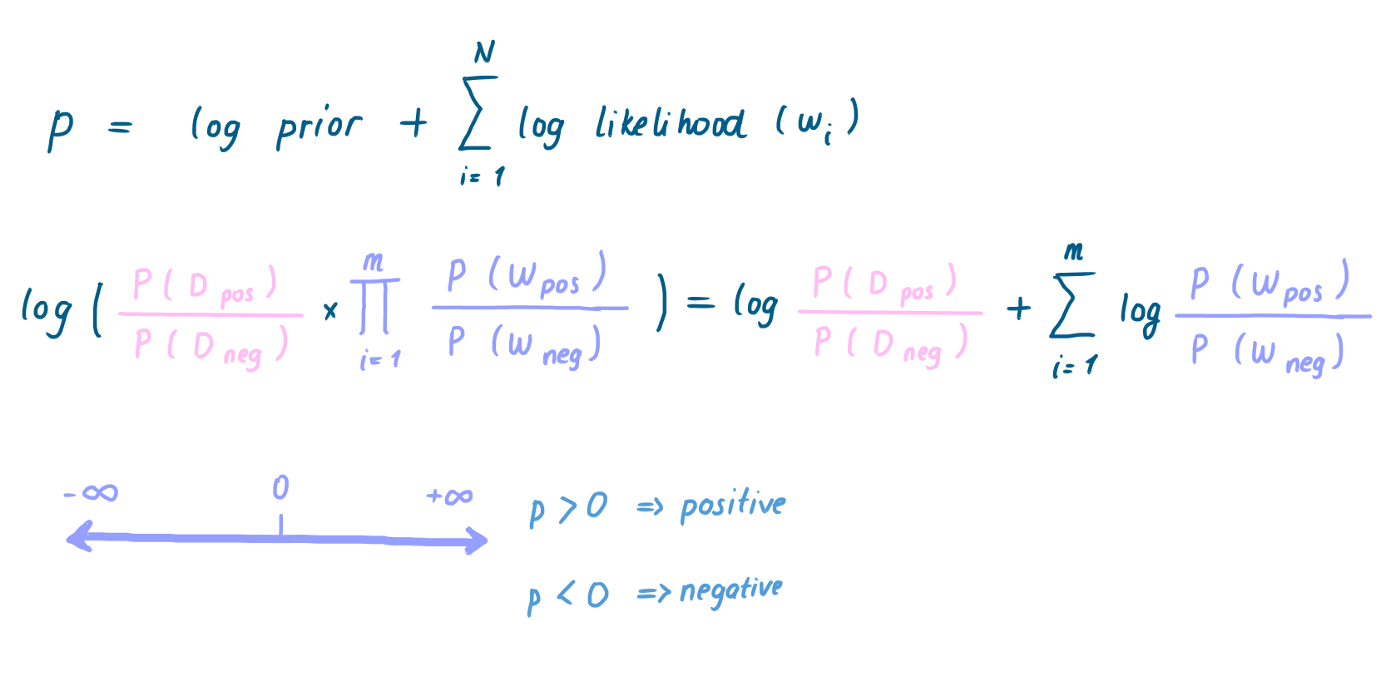

In [3]:
from IPython.display import Image
Image("images/prior.png", width=600)

**Prior** is the ratio of the number of positive to negative tweets in the dataset. In this case, prior didn’t need to be considered because the dataset is balanced that means the dataset is including exactly same number of positive and negative tweets. However, when the dataset is imbalanced, we need to multiply prior with likelihood.

When calculating the probability we are multiplying lots of numbers between 0 and 1. For preventing the possibility of a numerical underflow issue we will take the logarithms of likelihood and prior. Logarithm converts product of numbers to an addition operation and the formula turns into this :

If the result of this formula is positive, the tweet is also positive otherwise if it is less than 0 would indicate that the tweet is negative.

So we can start to implement the Naive Bayes algorithm using train_naive_bayes() that takes three arguments: freqs, the frequency dictionary that was built previously, train_x, %80 of the dataset that split previously and train_y, the labels belongs to the train_x.

train_naive_bayes() returns logprior value of the dataset and loglikelihood as the dictionary of the word and its log likelihood as key value pair.

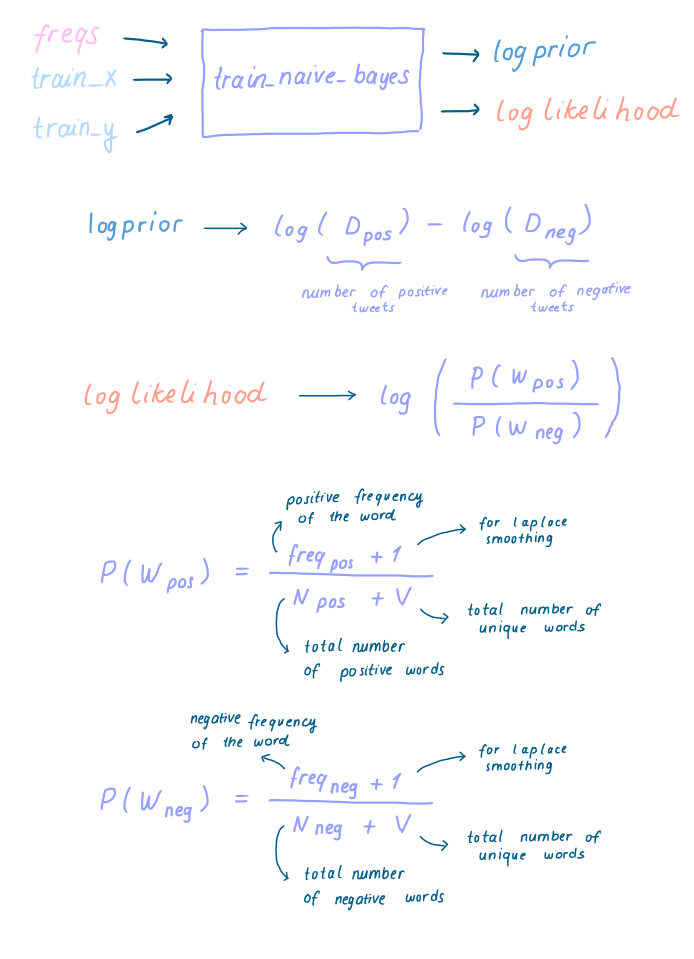

In [6]:
from IPython.display import Image
Image("images/nb2.png", width=600)

# Laplace Smoothing

We use Laplacian smoothing when calculating the probabilities in log likelihood equation. We add 1 to the frequency value to avoid getting 0 as probability. V is the total number of unique words in all dataset and added to denominator for accounting extra 1's added.

In [7]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of tweets
        train_y: a list of labels correponding to the tweets (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of Naive bayes equation.
    '''
    loglikelihood = {}
    logprior = 0

    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    # calculate N_pos and N_neg
    N_pos = N_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:

            # Increment the number of positive words by the count for this (word, label) pair
            N_pos += freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            N_neg += freqs[pair]

    # Calculate D, the number of documents
    D = len(train_y)

    # Calculate D_pos, the number of positive documents (*hint: use sum(<np_array>))
    D_pos = (len(list(filter(lambda x: x > 0, train_y))))

    # Calculate D_neg, the number of negative documents (*hint: compute using D and D_pos)
    D_neg = (len(list(filter(lambda x: x <= 0, train_y))))

    # Calculate logprior
    logprior = np.log(D_pos) - np.log(D_neg)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = lookup(freqs,word,1)
        freq_neg = lookup(freqs,word,0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)

    return logprior, loglikelihood

# 3. Test the model

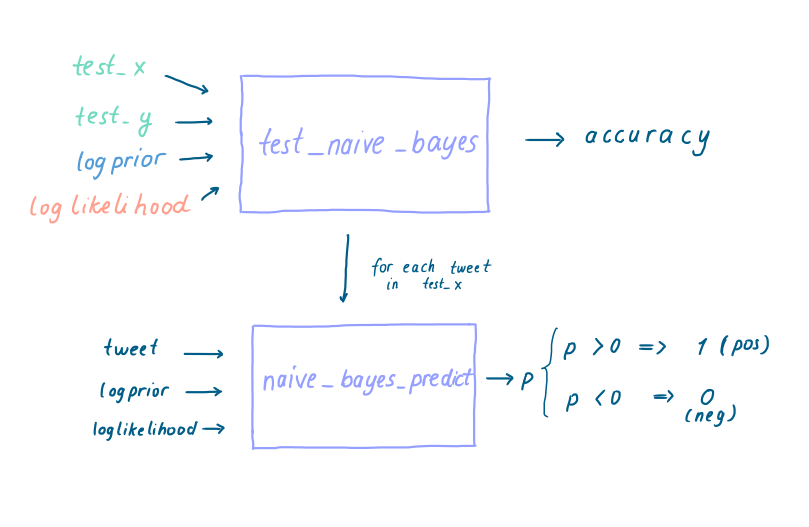

In [8]:
from IPython.display import Image
Image("images/testing.png", width=600)

**test_naive_bayes()** function tests the performance of the Naive Bayes model in the test_x dataset that split as %20 of the dataset previously. For each tweet in the test_x, naive_bayes_predict() function calculates p value, sum of logprior and loglikelihood that belongs to the words in this tweet and label the tweet positive if p is greater than 0, otherwise negative. Accuracy calculated comparing the predicted labels with labels in test_y.

In [9]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    '''
    Input:
        tweet: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Output:
        p: the sum of all the logliklihoods of each word in the tweet (if found in the dictionary) + logprior (a number)

    '''
    # process the tweet to get a list of words
    word_l = process_tweet(tweet)

    # initialize probability to zero
    p = 0

    # add the logprior
    p += logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            p += loglikelihood[word]

    return p

In [10]:
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of tweets
        test_y: the corresponding labels for the list of tweets
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of tweets classified correctly)/(total # of tweets)
    """
    accuracy = 0  # return this properly

    y_hats = []
    for tweet in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.mean(np.absolute(y_hats-test_y))

    # Accuracy is 1 minus the error
    accuracy = 1-error

    return accuracy